# Import libraries

In [1]:
suppressPackageStartupMessages({
    library(dplyr)
    library(ggpubr)
    library(SingleCellExperiment)
})

# Load data

In [2]:
fn  <- here::here("inputs/hlca/_m/hlca_core.h5ad")
sce <- zellkonverter::readH5AD(fn)
sce

Registered S3 methods overwritten by 'zellkonverter':
  method                                             from      
  py_to_r.numpy.ndarray                              reticulate
  py_to_r.pandas.core.arrays.categorical.Categorical reticulate



class: SingleCellExperiment 
dim: 28024 584944 
metadata(6): batch_condition citation ... schema_version title
assays(1): X
rownames(28024): ENSG00000000003 ENSG00000000005 ... ENSG00000283118
  ENSG00000283125
rowData names(5): feature_is_filtered feature_name feature_reference
  feature_biotype feature_length
colnames(584944): GCGACCATCCCTAACC_SC22 P2_1_GCGCAACCAGTTAACC ...
  CGATGGCAGCAGGCTA-1-2 AATCGGTGTCGGCACT-1-4
colData names(69): suspension_type donor_id ... development_stage
  observation_joinid
reducedDimNames(2): X_scanvi_emb X_umap
mainExpName: NULL
altExpNames(0):

In [3]:
colData(sce) |> colnames()

[1] "suspension_type"                            
 [2] "donor_id"                                   
 [3] "is_primary_data"                            
 [4] "assay_ontology_term_id"                     
 [5] "cell_type_ontology_term_id"                 
 [6] "development_stage_ontology_term_id"         
 [7] "disease_ontology_term_id"                   
 [8] "self_reported_ethnicity_ontology_term_id"   
 [9] "tissue_ontology_term_id"                    
[10] "organism_ontology_term_id"                  
[11] "sex_ontology_term_id"                       
[12] "BMI"                                        
[13] "age_or_mean_of_age_range"                   
[14] "age_range"                                  
[15] "anatomical_region_ccf_score"                
[16] "ann_coarse_for_GWAS_and_modeling"           
[17] "ann_finest_level"                           
[18] "ann_level_1"                                
[19] "ann_level_2"                                
[20] "ann_level_3"                                
[21] "ann_level_4"                                
[22] "ann_level_5"                                
[23] "cause_of_death"                             
[24] "dataset"                                    
[25] "entropy_dataset_leiden_3"                   
[26] "entropy_original_ann_level_1_leiden_3"      
[27] "entropy_original_ann_level_2_clean_leiden_3"
[28] "entropy_original_ann_level_3_clean_leiden_3"
[29] "entropy_subject_ID_leiden_3"                
[30] "fresh_or_frozen"                            
[31] "leiden_1"                                   
[32] "leiden_2"                                   
[33] "leiden_3"                                   
[34] "leiden_4"                                   
[35] "leiden_5"                                   
[36] "log10_total_counts"                         
[37] "lung_condition"                             
[38] "mixed_ancestry"                             
[39] "n_genes_detected"                           
[40] "original_ann_highest_res"                   
[41] "original_ann_level_1"                       
[42] "original_ann_level_2"                       
[43] "original_ann_level_3"                       
[44] "original_ann_level_4"                       
[45] "original_ann_level_5"                       
[46] "original_ann_nonharmonized"                 
[47] "reannotation_type"                          
[48] "reference_genome"                           
[49] "sample"                                     
[50] "scanvi_label"                               
[51] "sequencing_platform"                        
[52] "size_factors"                               
[53] "smoking_status"                             
[54] "study"                                      
[55] "subject_type"                               
[56] "tissue_dissociation_protocol"               
[57] "tissue_level_2"                             
[58] "tissue_level_3"                             
[59] "tissue_sampling_method"                     
[60] "tissue_type"                                
[61] "cell_type"                                  
[62] "assay"                                      
[63] "disease"                                    
[64] "organism"                                   
[65] "sex"                                        
[66] "tissue"                                     
[67] "self_reported_ethnicity"                    
[68] "development_stage"                          
[69] "observation_joinid"

In [4]:
colData(sce)$subclusters <- sce$ann_finest_level
colData(sce)$clusters    <- sce$cell_type
colData(sce)$cell_type   <- sce$ann_coarse_for_GWAS_and_modeling
colData(sce)$compartment <- sce$ann_level_1
colData(sce)$patient     <- sce$donor_id
colData(sce)$age         <- sce$age_or_mean_of_age_range
colLabels(sce) <- sce$cell_type

In [5]:
names(assays(sce)) <- "counts"
sce <- scuttle::logNormCounts(sce)
sce <- scran::computeSumFactors(sce)
sce

class: SingleCellExperiment 
dim: 28024 584944 
metadata(6): batch_condition citation ... schema_version title
assays(2): counts logcounts
rownames(28024): ENSG00000000003 ENSG00000000005 ... ENSG00000283118
  ENSG00000283125
rowData names(5): feature_is_filtered feature_name feature_reference
  feature_biotype feature_length
colnames(584944): GCGACCATCCCTAACC_SC22 P2_1_GCGCAACCAGTTAACC ...
  CGATGGCAGCAGGCTA-1-2 AATCGGTGTCGGCACT-1-4
colData names(76): suspension_type donor_id ... label sizeFactor
reducedDimNames(2): X_scanvi_emb X_umap
mainExpName: NULL
altExpNames(0):

# QC

In [6]:
is_mito <- grep("MT-", rowData(sce)$feature_name)
sce     <- scuttle::addPerCellQCMetrics(sce, subsets=list(mito=is_mito))
sce     <- scuttle::addPerFeatureQCMetrics(sce)

## Find outliers

In [7]:
                                        # Mitochondria percentage
print(summary(sce$subsets_mito_percent))
## The percentage is very small, so will not add additional filtering
qc_stats <- scuttle::perCellQCFilters(sce)
print(colSums(as.matrix(qc_stats)))
                                        # Discard outliers
sce      <- sce[, !qc_stats$discard]
sce

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.360   1.643   1.750   2.031  11.735 
  low_lib_size low_n_features        discard 
          3551              0           3551 


class: SingleCellExperiment 
dim: 28024 581393 
metadata(6): batch_condition citation ... schema_version title
assays(2): counts logcounts
rownames(28024): ENSG00000000003 ENSG00000000005 ... ENSG00000283118
  ENSG00000283125
rowData names(7): feature_is_filtered feature_name ... mean detected
colnames(581393): GCGACCATCCCTAACC_SC22 P2_1_GCGCAACCAGTTAACC ...
  CGATGGCAGCAGGCTA-1-2 AATCGGTGTCGGCACT-1-4
colData names(82): suspension_type donor_id ... subsets_mito_percent
  total
reducedDimNames(2): X_scanvi_emb X_umap
mainExpName: NULL
altExpNames(0):

# Extract angiotensin receptors

In [9]:
assays(sce)$counts[1:2, 1:5]

2 x 5 sparse Matrix of class "dgCMatrix"
                GCGACCATCCCTAACC_SC22 P2_1_GCGCAACCAGTTAACC
ENSG00000000003                     .                     .
ENSG00000000005                     .                     .
                GCTCTGTAGTGCTGCC_SC27 P2_8_TTAGGACGTTCAGGCC
ENSG00000000003                     .                     .
ENSG00000000005                     .                     .
                CTTGATTGTCAGTTTG_T164
ENSG00000000003             0.3357006
ENSG00000000005             .        

In [10]:
rownames(sce) <- rowData(sce)[, 2] # Change rownames to gene names
genes = c("AGTR1", "AGTR2") # Select angiotensin II genes
angiotensin2 <- sce[genes,]
angiotensin2

class: SingleCellExperiment 
dim: 2 581393 
metadata(6): batch_condition citation ... schema_version title
assays(2): counts logcounts
rownames(2): AGTR1 AGTR2
rowData names(7): feature_is_filtered feature_name ... mean detected
colnames(581393): GCGACCATCCCTAACC_SC22 P2_1_GCGCAACCAGTTAACC ...
  CGATGGCAGCAGGCTA-1-2 AATCGGTGTCGGCACT-1-4
colData names(82): suspension_type donor_id ... subsets_mito_percent
  total
reducedDimNames(2): X_scanvi_emb X_umap
mainExpName: NULL
altExpNames(0):

# Prepare data functions

## All cells

In [18]:
df1 <- counts(angiotensin2) |> t() |> as.data.frame() |>
    mutate(Donor=colData(angiotensin2)$patient,
           Celltype=colData(angiotensin2)$cell_type,
           Compartment=colData(angiotensin2)$compartment,
           Age=colData(angiotensin2)$age) |>
    filter(AGTR1 > 0 | AGTR2 > 0) |> droplevels() |>
    tidyr::pivot_longer(-c(Donor, Celltype, Compartment, Age),
                        names_to="Gene_Name", values_to="Counts") |>
    mutate_if(is.character, as.factor)
dim(df1)

[1] 19104     6

In [19]:
head(df1, 2)

Donor,Celltype,Compartment,Age,Gene_Name,Counts
<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>
homosapiens_None_2023_None_sikkemalisa_001_d10_1101_2022_03_10_483747NU_CZI01,Adventitial fibroblasts,Stroma,52,AGTR1,0.2818444
homosapiens_None_2023_None_sikkemalisa_001_d10_1101_2022_03_10_483747NU_CZI01,Adventitial fibroblasts,Stroma,52,AGTR2,0.0000000


## Filtered for angiotensin positive cells

In [21]:
df2 = logcounts(angiotensin2) |> t() |> as.data.frame() |>
    mutate(Donor=colData(angiotensin2)$patient,
           Celltype=colData(angiotensin2)$cell_type,
           Compartment=colData(angiotensin2)$compartment,
           Age=colData(angiotensin2)$age) |>
    filter(AGTR1 > 0 | AGTR2 > 0) |> droplevels() |>
    tidyr::pivot_longer(-c(Donor, Celltype, Compartment, Age),
                        names_to="Gene_Name",
                        values_to="Normalized Expression") |>
    mutate_if(is.character, as.factor)
dim(df2)

[1] 19104     6

In [23]:
head(df2, 2)

Donor,Celltype,Compartment,Age,Gene_Name,Normalized Expression
<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>
homosapiens_None_2023_None_sikkemalisa_001_d10_1101_2022_03_10_483747NU_CZI01,Adventitial fibroblasts,Stroma,52,AGTR1,0.2774478
homosapiens_None_2023_None_sikkemalisa_001_d10_1101_2022_03_10_483747NU_CZI01,Adventitial fibroblasts,Stroma,52,AGTR2,0.0000000


# Plotting: association with age

In [45]:
save_ggplots <- function(fn, p, w, h){
    for(ext in c('.pdf', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

## General age

In [27]:
df1 |> group_by_at(c("Gene_Name", "Donor")) |>
    reframe(tot_ct = sum(Counts), Age=Age) |> distinct() |> head(2)

Gene_Name,Donor,tot_ct,Age
<fct>,<fct>,<dbl>,<dbl>
AGTR1,homosapiens_None_2023_None_sikkemalisa_001_d10_1101_2022_03_10_4837472020-3173-NC004,3.311517,27.0
AGTR1,homosapiens_None_2023_None_sikkemalisa_001_d10_1101_2022_03_10_483747284C,0.000000,57.5


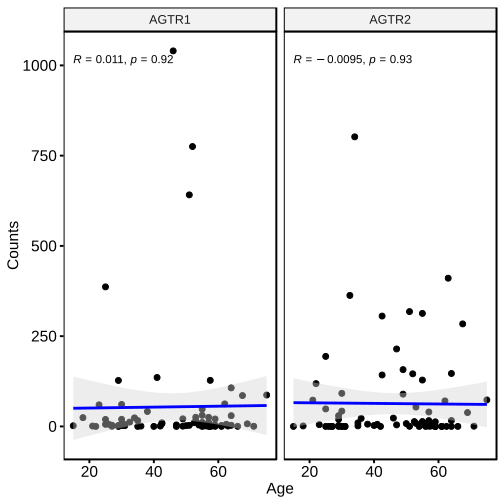

In [43]:
sca1 = df1 |> group_by_at(c("Gene_Name", "Donor")) |>
   reframe(tot_ct = sum(Counts), Age=mean(Age)) |> distinct() |> 
   ggscatter(x="Age", y="tot_ct", facet.by="Gene_Name",
             panel.labs.font=list(face='bold'),
             add="reg.line", conf.int=TRUE, cor.coef=TRUE, ylab="Counts", 
             add.params=list(color="blue", fill="lightgray"),    
             ggtheme=theme_pubr(base_size=15, border=TRUE))
sca1

In [49]:
save_ggplots("scatter_counts", sca1, 6, 4)

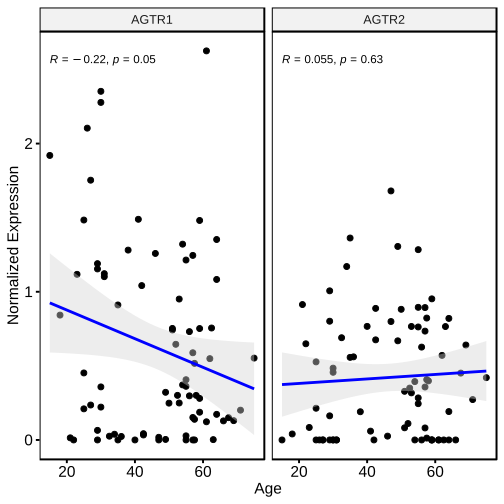

In [44]:
sca2 = df2 |> group_by_at(c("Gene_Name", "Donor")) |>
   reframe(mean_exp = mean(`Normalized Expression`, na.rm=TRUE), 
           Age=mean(Age)) |> distinct() |> 
   ggscatter(x="Age", y="mean_exp", facet.by="Gene_Name",
             panel.labs.font=list(face='bold'),
             add="reg.line", conf.int=TRUE, cor.coef=TRUE, 
             ylab="Normalized Expression", 
             add.params=list(color="blue", fill="lightgray"),    
             ggtheme=theme_pubr(base_size=15, border=TRUE))
sca2

In [50]:
save_ggplots("scatter_expr", sca2, 6, 4)

## By Compartment

In [51]:
xlab = "Compartment"; cols=4

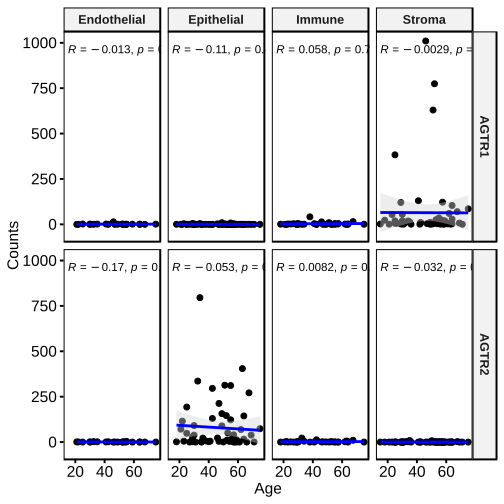

In [52]:
sca1 <- df1 |> group_by_at(c("Gene_Name", xlab, "Donor")) |>
        reframe(tot_ct = sum(Counts), Age=Age) |> distinct() |>
        ggscatter(x="Age", y="tot_ct", facet.by=c("Gene_Name", xlab),
                  add="reg.line", conf.int=TRUE, cor.coef=TRUE, 
                  panel.labs.font=list(face='bold'), ylab="Counts", 
                  add.params=list(color="blue", fill="lightgray"),    
                  ggtheme=theme_pubr(base_size=15, border=TRUE), ncol=cols)
sca1

In [53]:
save_ggplots(paste0("scatter_counts.", tolower(xlab)), 
             sca1, 12, 8)

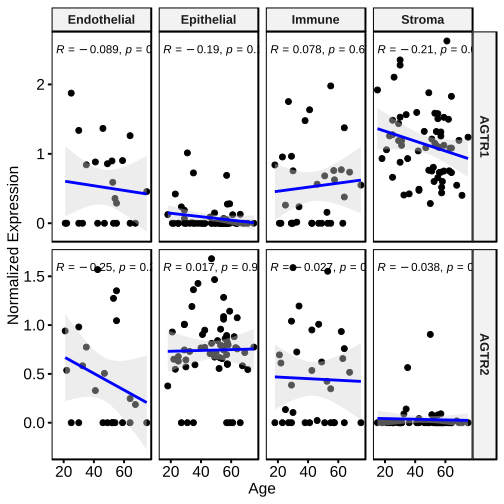

In [54]:
sca2 <- df2 |> group_by_at(c("Gene_Name", xlab, "Donor")) |>
        reframe(mean_exp = mean(`Normalized Expression`, na.rm=TRUE),
                  Age=Age) |> distinct() |>
        ggscatter(x="Age", y="mean_exp", facet.by=c("Gene_Name", xlab),
                  add="reg.line", conf.int=TRUE, cor.coef=TRUE, 
                  ylab="Normalized Expression", panel.labs.font=list(face='bold'),
                  add.params=list(color="blue", fill="lightgray"),
                  ggtheme=theme_pubr(base_size=15, border=TRUE), 
                  ncol=cols, scales="free_y")
sca2

In [56]:
save_ggplots(paste0("scatter_expr.", tolower(xlab)), 
             sca2, 12, 8)

## By Cell types

In [70]:
xlab = "Celltype"; cols=5

Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


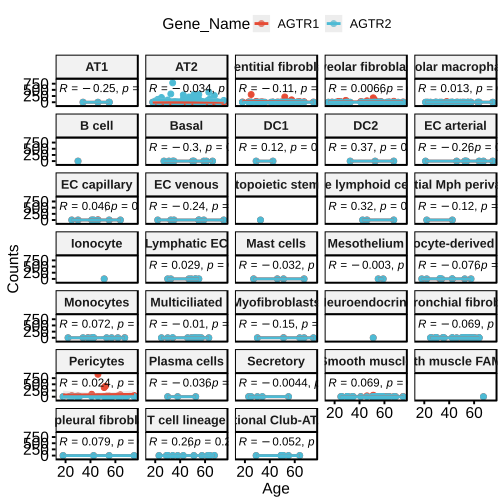

In [65]:
sca1 <- df1 |> group_by_at(c("Gene_Name", xlab, "Donor")) |>
        reframe(tot_ct = sum(Counts), Age=Age) |> distinct() |>
        ggscatter(x="Age", y="tot_ct", color="Gene_Name", palette="npg",
                  facet.by=xlab, add="reg.line", conf.int=TRUE, cor.coef=TRUE, 
                  panel.labs.font=list(face='bold'), ylab="Counts", 
                  add.params=list(fill="lightgray"),    
                  ggtheme=theme_pubr(base_size=15, border=TRUE), 
                  ncol=5)
sca1

In [66]:
save_ggplots(paste0("scatter_counts.", tolower(xlab)), 
             sca1, 12, 12)

Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2,

Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


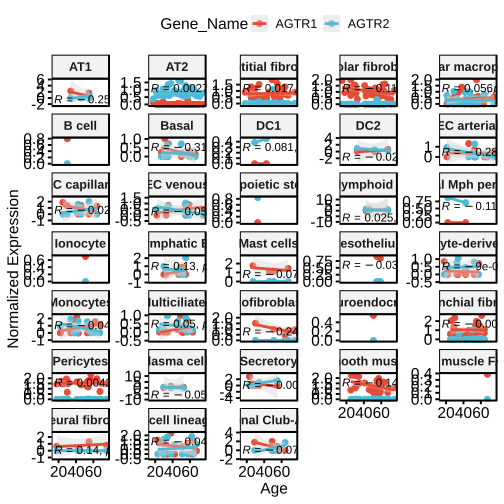

In [71]:
sca2 <- df2 |> group_by_at(c("Gene_Name", xlab, "Donor")) |>
        reframe(mean_exp = mean(`Normalized Expression`, na.rm=TRUE),
                  Age=Age) |> distinct() |>
        ggscatter(x="Age", y="mean_exp", color="Gene_Name", palette="npg",
                  facet.by=xlab,add="reg.line", conf.int=TRUE, cor.coef=TRUE, 
                  ylab="Normalized Expression", panel.labs.font=list(face='bold'),
                  add.params=list(fill="lightgray"),
                  ggtheme=theme_pubr(base_size=15, border=TRUE), 
                  ncol=cols, scales="free_y")
sca2

In [72]:
save_ggplots(paste0("scatter_expr.", tolower(xlab)), 
             sca2, 12, 12)

Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2,

# Statistics

In [88]:
model = paste("`Normalized Expression` ~ Age*", xlab)
est_fit <- df2 |> group_by(Gene_Name) |>
    do(fitEST=broom::tidy(lm(model, data=.))) |>
    tidyr::unnest(fitEST) |> filter(term != "(Intercept)") |>
        mutate(p.bonf = p.adjust(p.value, "bonf"),
               p.bonf.sig = p.bonf < 0.05,
               p.bonf.cat = cut(p.bonf,
                                breaks = c(1,0.05, 0.01, 0.005, 0),
                                labels = c("<= 0.005","<= 0.01", "<= 0.05", "> 0.05"),
                                include.lowest = TRUE),
               p.fdr = p.adjust(p.value, "fdr"),
               log.p.bonf = -log10(p.bonf),
               term = gsub(xlab, "", term))

In [90]:
dplyr::count(est_fit, Gene_Name, p.bonf.cat)

Gene_Name,p.bonf.cat,n
<fct>,<fct>,<int>
AGTR1,<= 0.005,26
AGTR1,<= 0.01,4
AGTR1,<= 0.05,5
AGTR1,> 0.05,25
AGTR1,NA,5
AGTR2,> 0.05,60
AGTR2,NA,5


In [ ]:
statistics_byGene <- function(df, xlab){
    model = paste("`Normalized Expression` ~", xlab)
    est_fit <- df |> group_by(Gene_Name, Age) |>
        do(fitEST=broom::tidy(lm(model, data=.))) |>
        tidyr::unnest(fitEST) |> filter(term != "(Intercept)") |>
        mutate(p.bonf = p.adjust(p.value, "bonf"),
               p.bonf.sig = p.bonf < 0.05,
               p.bonf.cat = cut(p.bonf,
                                breaks = c(1,0.05, 0.01, 0.005, 0),
                                labels = c("<= 0.005","<= 0.01", "<= 0.05", "> 0.05"),
                                include.lowest = TRUE),
               p.fdr = p.adjust(p.value, "fdr"),
               log.p.bonf = -log10(p.bonf),
               term = gsub(xlab, "", term))
    ##print(est_fit |> dplyr::count(Gene_Name, Age, p.bonf.cat))
    return(est_fit)
}